# Topology Optimization of a Solid Body

In [14]:
import pyvista as pv
import numpy as np
from polymesh.examples import stand_vtk
from polymesh import PointCloud
from polymesh import CartesianFrame
from sigmaepsilon.solid import Structure, PointData, SolidMesh
from sigmaepsilon.solid.fem.cells import TET10 as CellData

pd = stand_vtk(read=True)


In [15]:
G = 10.0  # kg
g = 9.81  # m/s2
h = 100.0  # mm
E = 5000.  # Young's mpdulus
nu = 0.2  # Poisson's ratio


In [16]:
# scale model to have the desired height
[[xmin, xmax], [ymin, ymax], [zmin, zmax]] = pd.bounds()
ratio = h / (zmax - zmin)
pc = PointCloud(pd.coords(), frame=pd.frame)
pc.centralize()
pc = PointCloud(pc * ratio, frame=pd.frame)
[[xmin, xmax], [ymin, ymax], [zmin, zmax]] = pc.bounds()
pc.move([0., 0., -zmin])
[[xmin, xmax], [ymin, ymax], [zmin, zmax]] = pc.bounds()
assert np.abs(zmin) < 1e-12
assert np.isclose(h, zmax - zmin)


In [17]:
coords = pc.show()
topo = pd.topology()
# istoropic material
A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))
# nodal loads
cond = coords[:, 2] >= (zmax - 6)
i = np.where(cond)[0]
nodal_loads = np.zeros((len(coords), 3), dtype=float)
nodal_loads[i, 2] = - (G * g) / len(i)
# nodal supports
cond = coords[:, 2] < 6
i = np.where(cond)[0]
fixity = np.zeros((len(coords), 3), dtype=bool)
fixity[i, :] = True
# pointdata and celldata
GlobalFrame = CartesianFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=nodal_loads, fixity=fixity)
# cells
cd = CellData(topo=topo, frames=GlobalFrame)
# mesh
mesh = SolidMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
# plot
structure.mesh.pd['x'] = coords + dofsol[:, :3]
structure.mesh.pd['scalars'] = dofsol[:, 2]


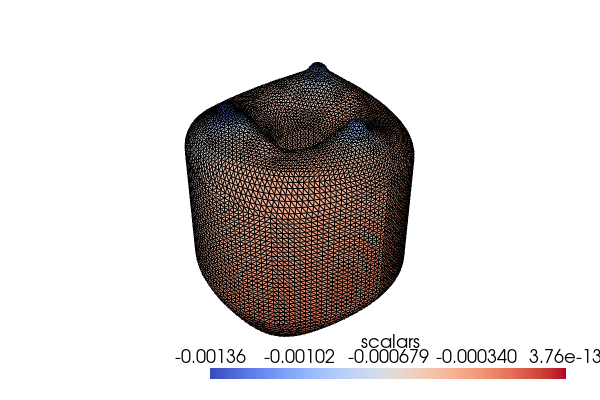

In [18]:
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='coolwarm',
            jupyter_backend='static', scalars='scalars')

Plot the model, coloured with vertical displacements:

In [19]:
pl = pv.Plotter(notebook=False)
pl = mesh.plot(plotter=pl, cmap='coolwarm', scalars='scalars')
pl.show()
